In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fmin_powell
from scipy import integrate

#import theano as thno
#import theano.tensor as T

In [2]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init='adapt_diag')

    return models, traces

In [3]:
raw_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                       header=None,
                       names=['age', 'workclass', 'fnlwgt',
                              'education-categorical', 'educ',
                              'marital-status', 'occupation',
                              'relationship', 'race', 'sex',
                              'captial-gain', 'capital-loss',
                              'hours', 'native-country',
                              'income'])

In [4]:
raw_data.head(10)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [5]:
data = raw_data[~pd.isnull(raw_data['income'])]

In [6]:
data[data['native-country']==" United-States"].sample(5)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
14187,31,Private,59496,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,50,United-States,<=50K
29287,25,Private,229287,Bachelors,13,Never-married,Exec-managerial,Other-relative,White,Female,0,0,25,United-States,<=50K
19656,33,Private,171215,Masters,14,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,United-States,<=50K
13161,65,?,137354,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,20,United-States,<=50K
27689,49,Private,200198,HS-grad,9,Married-civ-spouse,Other-service,Husband,Black,Male,0,0,40,United-States,<=50K


In [7]:
income = 1 * (data['income'] == " >50K")

In [8]:
data = data[['age', 'educ', 'hours']]

# Scale age by 10, it helps with model convergence.
data['age'] = data['age']/10.
data['age2'] = np.square(data['age'])
data['income'] = income

In [9]:
income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

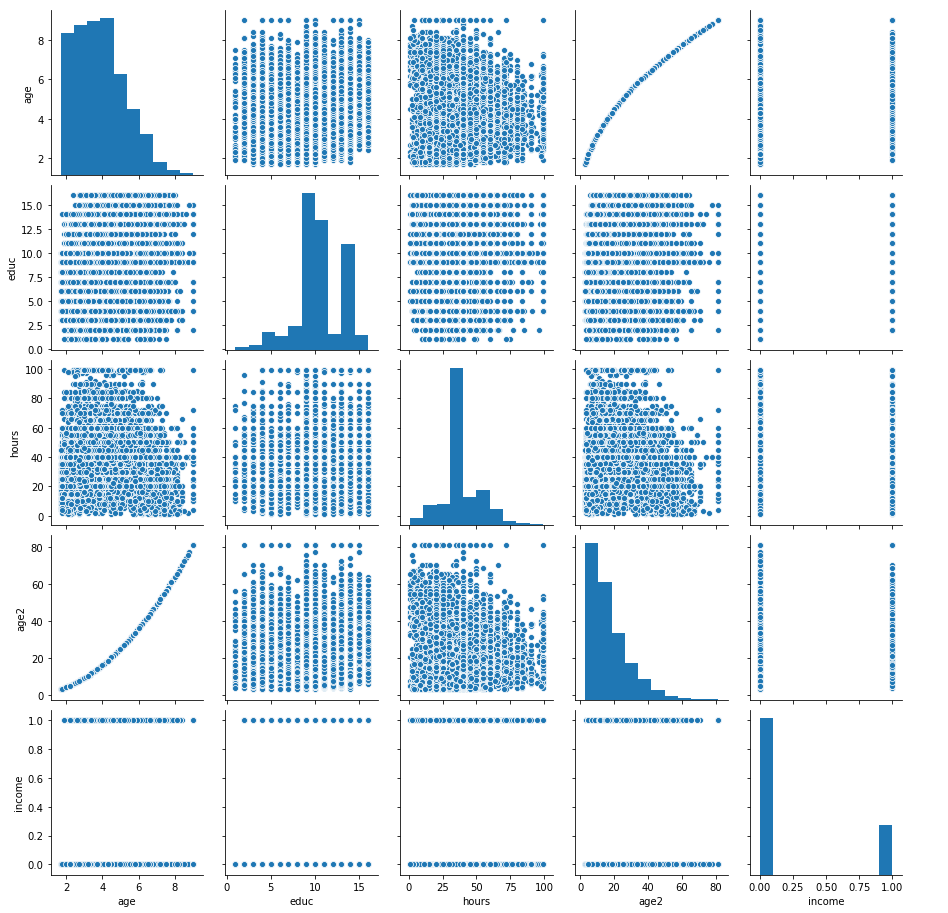

In [10]:
g = seaborn.pairplot(data)

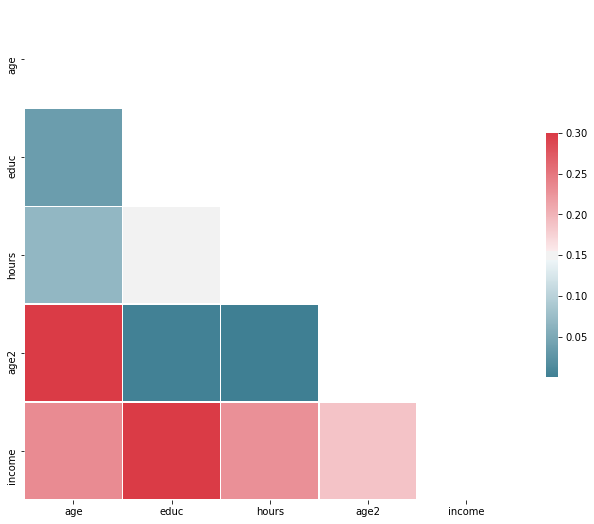

In [11]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('income ~ age + age2 + educ + hours',
                            data,
                            family=pm.glm.families.Binomial())
    trace = pm.sample(1000, tune=1000, init='adapt_diag', cores=1)